# this note book will demonstrate how to simulate diffraction pattern

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

from hexomap import reconstruction  # g-force caller
from hexomap import MicFileTool     # io for reconstruction rst
from hexomap import IntBin          # io for binary image (reduced data)

In [2]:
# set up configuration:
import sys
sys.path.insert(0, '..')
from hexomap import config
import numpy as np

Au_Config={
    'micsize' : np.array([20, 20]),
    'micVoxelSize' : 0.001,
    'micShift' : np.array([0.0, 0.0, 0.0]),
    'expdataNDigit' : 6,
    'energy' : 65.351,      #55.587 # in kev
    'sample' : 'gold',
    'maxQ' : 9,
    'etalimit' : 81 / 180.0 * np.pi,
    'NRot' : 180,
    'NDet' : 2,
    'searchBatchSize' : 6000,
    'reverseRot' : True,          # for aero, is True, for rams: False
    'detL' : np.array([[ 4.5, 6.5]]),
    'detJ' : np.array([[1020.4672, 1035.6063]]),
    'detK' : np.array([[1995.8868, 1990.6409]]),
    'detRot' : np.array([[[90, 90, 0],
                  [90, 90, 0]]]),
    'fileBin' : '../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z',
    'fileBinDigit' : 6,
    'fileBinDetIdx' : np.array([0, 1]),
    'fileBinLayerIdx' : 0,
    '_initialString' : 'demo_gold_'}
    
c = config.Config(**Au_Config)
print(c)


Configurations:
micsize                        [20 20]
micVoxelSize                   0.001
micShift                       [0. 0. 0.]
expdataNDigit                  6
energy                         65.351
sample                         gold
maxQ                           9
etalimit                       1.413716694115407
NRot                           180
NDet                           2
searchBatchSize                6000
reverseRot                     True
detL                           [[4.5 6.5]]
detJ                           [[1020.4672 1035.6063]]
detK                           [[1995.8868 1990.6409]]
detRot                         [[[90 90  0]
  [90 90  0]]]
fileBin                        ../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z
fileBinDigit                   6
fileBinDetIdx                  [0 1]
fileBinLayerIdx                0
_initialString                 demo_gold_


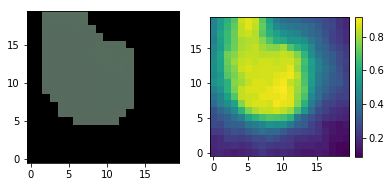

set Q automatically to 9
(146, 3)
(146, 3, 3)
============start of simulation ============= 

nvoxel: 146, norientation:1.0

============end of simulation================ 

SourceModule time 0.0003112640082836151 seconds.


1

In [3]:
from hexomap import reconstruction
from hexomap import MicFileTool
# load structure to simulate
mic = np.load('demo_gold__q9_rot180_z0_20x20_0.005_shift_0.0_0.0_0.0.npy') 
mask = mic[:,:,6]> 0.6 # only simulate where hitratio>0.6

# visualize mic structure
MicFileTool.plot_mic_and_conf(mic, 0.6)

S = reconstruction.Reconstructor_GPU()
S.load_config(c,reloadData=False)  # load config but not raw images
S.squareMicData = mic
S.sim_mic(simMask=mic[:,:,6]>0.6)
S.save_sim_mic_binary('simulated_demo_gold/demo_gold_sim_')

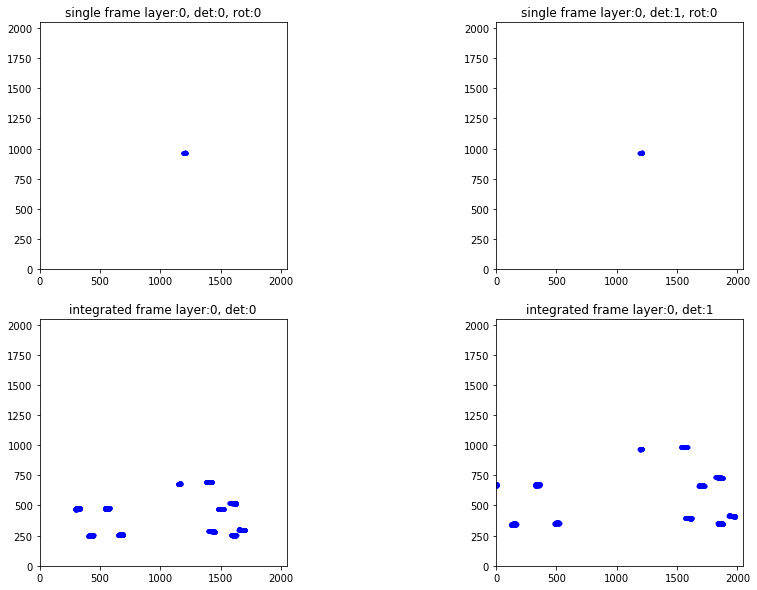

In [4]:
from hexomap import IntBin          # io for binary image (reduced data)
import matplotlib.pyplot as plt
import numpy as np
rawInitial = 'simulated_demo_gold/demo_gold_sim_z'
NRot = 30   # only number of images to display, doen't have to be all images(no need set to 180 or 720.can be some thing like 10)
NDet = 2
idxLayer = 0
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(2, NDet)
for idxDet in range(NDet):
    # single frame
    idxRot = 0  # index of rotation (0~719)
    b=IntBin.ReadI9BinaryFiles(f'{rawInitial}{idxLayer}_{0:06d}.bin{1}'.format(int(idxRot),idxDet))
    ax[0,idxDet].plot(2047-b[0],2047-b[1],'b.')
    ax[0,idxDet].axis('scaled')
    ax[0,idxDet].set_xlim((0,2048))
    ax[0,idxDet].set_ylim((0,2048))
    ax[0,idxDet].set_title(f'single frame layer:{idxLayer}, det:{idxDet}, rot:{idxRot}')
    
    # integrated frame:
    lX = []
    lY = []
    for idxRot in range(NRot):
        #print(b)
        b = IntBin.ReadI9BinaryFiles(f'{rawInitial}{idxLayer}_{idxRot:06d}.bin{idxDet}')
        lX.append(b[0])
        lY.append(b[1])
    aX = np.concatenate(lX)
    aY = np.concatenate(lY)
    ax[1,idxDet].plot(2047-aX,2047-aY,'b.')  
    ax[1,idxDet].axis('scaled')
    ax[1,idxDet].set_xlim((0,2048))
    ax[1,idxDet].set_ylim((0,2048))
    ax[1,idxDet].set_title(f'integrated frame layer:{idxLayer}, det:{idxDet}')

plt.show()